# Homework 3 - Data vizualisation

In [1]:
%matplotlib inline
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("husl")

# Task 1 : European unemployment rates

### Load dataset
To begin, we download a dataset on the [Eurostat](http://ec.europa.eu/eurostat/data/database) website by using the search bar and looking for the term *Unemployment*. We have chosen the dataset called "Total umemployment rate" (*tsdec450*) that contains unemployment rates per year, for each european country.

In [2]:
total_unemployment_file_path = 'data/tsdec450.tsv'

# load the data
def load_data(file_name):
    df = pd.DataFrame()
    df = df.append( pd.read_csv(file_name, sep="\t" , header=0))
    df.columns = [i.split(" ")[0] for i in df.columns]
    df.columns = [i.split("\\")[0] for i in df.columns]
    new_col = df["age,unit,sex,geo"].str.split(",")
    df["State"] = [pi[3] for pi in new_col]
    df["Unit"] = [pi[1] for pi in new_col]
    
    return df

df = load_data(total_unemployment_file_path)
df.head()

,"age,unit,sex,geo",1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2009,2010,2011,2012,2013,2014,2015,2016,State,Unit
0,"TOTAL,PC_ACT,T,AT",:,:,:,:,4.3,4.2,4.7,4.7,4.7,...,5.3,4.8,4.6,4.9,5.4,5.6,5.7,6.0,AT,PC_ACT
1,"TOTAL,PC_ACT,T,BE",6.6,6.4,7.1,8.6,9.8,9.7,9.5,9.2,9.3,...,7.9,8.3,7.2,7.6,8.4,8.5,8.5,7.8,BE,PC_ACT
2,"TOTAL,PC_ACT,T,BG",:,:,:,:,:,:,:,:,:,...,6.8,10.3 i,11.3,12.3,13.0,11.4,9.2,7.6,BG,PC_ACT
3,"TOTAL,PC_ACT,T,CY",:,:,:,:,:,:,:,:,:,...,5.4,6.3,7.9,11.9,15.9,16.1,15.0,13.0,CY,PC_ACT
4,"TOTAL,PC_ACT,T,CZ",:,:,:,4.3,4.3,4.0,3.9,4.8,6.5,...,6.7,7.3,6.7,7.0,7.0,6.1,5.1,4.0,CZ,PC_ACT


In [3]:
#Pre-processing : keep only useful data
df['2016'] = df['2016'].astype(float)
df = df.query('Unit == \'PC_ACT\'')

# Put the same country code in the dataset and in json geo-coordinate files
df = df.replace('UK', 'GB')
df = df.replace('EL', 'GR')

### Define classification function
According to [GISGeography.com](http://gisgeography.com/choropleth-maps-data-classification/), we learn that selecting a data classification method is important in order to impact the reader. We decided to code and test two of them:
- **Equal Interval Data Classification** as *equal* : It divides the classes into equal groups of same interval length.
- **Quantile classification** as *quantile*: It arranges the classes to have the same quantity inside.

In [47]:
# define functions for classifying the unemployment
def define_threshold(df, column_name, classification='equal', classes=4):
    if classification == 'equal':
        min_val = df[column_name].min()
        max_val = df[column_name].max()
        bins = []
        bins.append(min_val - 0.001)
        for i in np.arange(1, classes):
            bins.append(((max_val - min_val)* i/classes) + min_val)
        bins.append(max_val + 0.001)
        return bins
    
    if classification == 'quantile':
        out, bins = pd.qcut(df[column_name], classes, retbins=True)
        return bins.tolist()

### Plot european map

In [48]:
geojson_path = 'topojson/europe.topojson.json'
topojson_path = json.load(open(geojson_path))

# Tip to not plot countries that were missing in the dataset
topojson_path['objects']['europe']['geometries'] = [feature for feature in topojson_path['objects']['europe']['geometries'] if (feature['id'] in df['State'].values)]

# Draw the map with our threshold classification function
eu_map = folium.Map([52.3, 9.7], tiles='cartodbpositron', zoom_start=3.6)
eu_map.choropleth(geo_data=topojson_path , data=df, topojson='objects.europe',
             columns=['State', '2016'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale=define_threshold(df, '2016', classification='quantile', classes=4),
             legend_name='Percentage of unemployment (%)')


eu_map
#eu_map.save('maps/unemployment_europe.html')

### Observations - TODO
We don't have the unemployment rate for Switzerland for now.
TODO

# Task 2 : Swiss unemployment rates
We should apply the same methodology to display the unemployment rates in Switzerland. We start by loading the dataset from Amstat website.

## 2.1 - Registered unemployed (chômeurs)

First, we decided to plot on the map the unemployement rate for **registered unemployed people only** (chômeurs in French)

### Load dataset

In [6]:
# load data for switzerland find on amstat
unemployment_switzerland_file_path = 'data/unemployment_suisse.csv'

def load_switzerland_data(file_name):
    df = pd.DataFrame()
    df = df.append( pd.read_csv(file_name, sep=',', encoding='utf-16', header=0))
    return df

# Preprocessing
switzerland_df = load_switzerland_data(unemployment_switzerland_file_path)
switzerland_df = switzerland_df.reset_index()
switzerland_df.columns = switzerland_df.loc[0]
switzerland_df = switzerland_df.query('Mesures == \'Taux de chômage\'')
switzerland_df['Total'] = switzerland_df['Total'].astype(float)

# Our swiss canton codes file
switzerland_geojson_path = 'data/swiss_cantons.json'
cantons = pd.read_json(switzerland_geojson_path, encoding='utf-8')

# Merge canton dataframe with swiss unemployment dataset from amstat
switzerland_df = pd.merge(cantons, switzerland_df, left_on='name', right_on='Canton')
switzerland_df = switzerland_df[['code', 'Total']]
switzerland_df.head()

,code,Total
0,ZH,3.7
1,BE,2.7
2,LU,2.1
3,UR,1.0
4,SZ,1.8


### Plot Switzerland map

TODO: Maybe the choice of the colors

In [7]:
switzerland_path = 'data/ch-cantons.topojson.json'
switzerland_topojson_path = json.load(open(switzerland_path))


switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson='objects.cantons',
             columns=['code', 'Total'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Unemployment rate (%)')


switzerland_map
switzerland_map.save('maps/unemployment_switzerland.html')

## 2.2 - Unemployment rate (employed and non-employed included)

In [8]:
#Load data
swiss_unemployed_filtered_path = 'data/details_unemployment.csv'
switzerland_unemployed_df = pd.read_csv(open(swiss_unemployed_filtered_path, encoding='utf-16'), header=[1,2], thousands='\'')

#Preprocessing
switzerland_unemployed_df = switzerland_unemployed_df[['Canton','Total']]
switzerland_unemployed_df.columns = ['canton', 'unemployment_rate', 'unemployed_jobseekers', 'all_jobseekers', 'employed_jobseekers']
switzerland_unemployed_df.drop(switzerland_unemployed_df.index[len(switzerland_unemployed_df)-1], inplace=True)

# Our swiss canton codes file
switzerland_geojson_path = 'data/swiss_cantons.json'
cantons = pd.read_json(switzerland_geojson_path, encoding='utf-8')

#cantons
cantons.drop(cantons.index[len(cantons)-1], inplace=True)
cantons.columns = ['code', 'canton']
switzerland_df = pd.merge(cantons,switzerland_unemployed_df, on=['canton'])
switzerland_df.head()

,code,canton,unemployment_rate,unemployed_jobseekers,all_jobseekers,employed_jobseekers
0,ZH,Zurich,3.7,361007,441431,80424
1,BE,Berne,2.7,183398,241011,57613
2,LU,Lucerne,2.1,55221,89599,34378
3,UR,Uri,1.0,2418,4361,1943
4,SZ,Schwyz,1.8,18446,27475,9029


### Compute new ratios
TODO : there is a problem i don"t understand this (ALEX)

In [9]:
switzerland_df['population'] = (switzerland_df['all_jobseekers']/switzerland_df['unemployment_rate'])*100
switzerland_df['unemployed_jobseekers_unemployment_rate'] = (switzerland_df['unemployed_jobseekers']/switzerland_df['population'])*100
switzerland_df.head()

,code,canton,unemployment_rate,unemployed_jobseekers,all_jobseekers,employed_jobseekers,population,unemployed_jobseekers_unemployment_rate
0,ZH,Zurich,3.7,361007,441431,80424,1.193057e+07,3.025900
1,BE,Berne,2.7,183398,241011,57613,8.926333e+06,2.054573
2,LU,Lucerne,2.1,55221,89599,34378,4.266619e+06,1.294257
3,UR,Uri,1.0,2418,4361,1943,4.361000e+05,0.554460
4,SZ,Schwyz,1.8,18446,27475,9029,1.526389e+06,1.208473


In [10]:
# show the difference in one graph plot

### Plot swiss map of employed jobseekers ?

In [11]:
switzerland_path = 'data/ch-cantons.topojson.json'
switzerland_topojson_path = json.load(open(switzerland_path))

switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson= 'objects.cantons',
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')

switzerland_map

In [12]:
switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_df, topojson= 'objects.cantons',
             columns=['code', 'unemployed_jobseekers_unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (%)')

switzerland_map

## Analysis : include employed jobseekers or not ?
Here, we will discuss on the different interpretations of "unemployement rate".

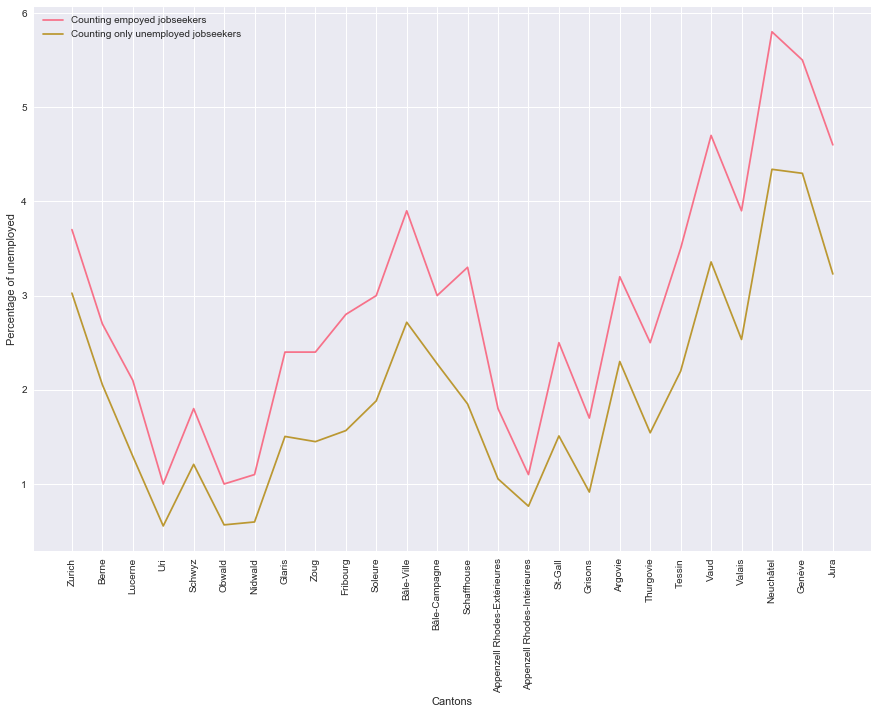

In [13]:
sns.axes_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
x = [i for i in np.arange(0, len(switzerland_df))]
ax.plot(x, switzerland_df.unemployment_rate)
ax.plot(x, switzerland_df.unemployed_jobseekers_unemployment_rate)
ax.set_ylabel("Percentage of unemployed")
ax.set_xlabel("Cantons")
plt.xticks(x, switzerland_df['canton'], rotation='vertical')
ax.legend(["Counting empoyed jobseekers", "Counting only unemployed jobseekers"])

# Task 3

Notes:
Here we also decided to take the previous year into account - 2016


In [14]:
switzerland_nationality_path = 'data/taux_chomage_nationality.csv'
switzerland_nationality_df = pd.read_csv(open(switzerland_nationality_path, encoding='utf-16'), header=[1,2], thousands='\'')
switzerland_nationality_df = switzerland_nationality_df[['Canton','Nationalité' ,'Total']]
switzerland_nationality_df.columns = ['canton', 'nationality', 'unemployment_rate', 'employed_jobseekers', 'all_jobseekers', 'unemployed_jobseekers']
switzerland_nationality_df.head()

,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,Zurich,Etrangers,6.0,164436,202818,38382
1,Zurich,Suisses,2.8,196571,238613,42042
2,Berne,Etrangers,6.5,69502,93346,23844
3,Berne,Suisses,2.0,113896,147665,33769
4,Lucerne,Etrangers,4.7,22927,39061,16134


In [15]:
#switzerland_nationality_df.groupby(['canton'])[['unemployment_rate']].sub
switzerland_all_nationality_df = pd.merge( cantons,switzerland_nationality_df, on=['canton'])

switzerland_strangers_df = switzerland_all_nationality_df.query('nationality == \'Etrangers\'') 
switzerland_suisses_df = switzerland_all_nationality_df.query('nationality == \'Suisses\'') 

switzerland_suisses_df.reset_index(inplace=True)

switzerland_strangers_df.reset_index(inplace=True)

switzerland_suisses_df.head()

,index,code,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,1,ZH,Zurich,Suisses,2.8,196571,238613,42042
1,3,BE,Berne,Suisses,2.0,113896,147665,33769
2,5,LU,Lucerne,Suisses,1.5,32294,50538,18244
3,7,UR,Uri,Suisses,0.6,1140,2091,951
4,9,SZ,Schwyz,Suisses,1.2,9999,14425,4426


In [16]:
switzerland_strangers_df.head()

,index,code,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers
0,0,ZH,Zurich,Etrangers,6.0,164436,202818,38382
1,2,BE,Berne,Etrangers,6.5,69502,93346,23844
2,4,LU,Lucerne,Etrangers,4.7,22927,39061,16134
3,6,UR,Uri,Etrangers,4.2,1278,2270,992
4,8,SZ,Schwyz,Etrangers,3.9,8447,13050,4603


In [17]:
#switzerland_strangers_df.sub(switzerland_suisses_df, axis=['unemployment_rate'])

#switzerland_diff_df['unemployment_rate'] = switzerland_strangers_df['unemployment_rate'].astype(float)
#switzerland_diff_df.head()


switzerland_diff_df = switzerland_suisses_df
switzerland_diff_df.loc[:,'unemployment_rate_difference'] = switzerland_strangers_df.loc[:,'unemployment_rate'].sub(switzerland_suisses_df.loc[:,'unemployment_rate'])
switzerland_diff_df.head()

C:\Users\rassinoux\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\rassinoux\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,index,code,canton,nationality,unemployment_rate,employed_jobseekers,all_jobseekers,unemployed_jobseekers,unemployment_rate_difference
0,1,ZH,Zurich,Suisses,2.8,196571,238613,42042,3.2
1,3,BE,Berne,Suisses,2.0,113896,147665,33769,4.5
2,5,LU,Lucerne,Suisses,1.5,32294,50538,18244,3.2
3,7,UR,Uri,Suisses,0.6,1140,2091,951,3.6
4,9,SZ,Schwyz,Suisses,1.2,9999,14425,4426,2.7


## Map of unemployment rate - difference between swiss and foreigners



On the map we show difference between the unemployment rate between swiss people and foregners. We notice that this difference is biggest in the next regions: ...

In [18]:
#Layer Control add to see both maps in one

m_switzerland_swiss_foreigners = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)
state_geo_path = '../topojson/ch-cantons.topojson.json'
geo_json_data = json.load(open(state_geo_path))

m_switzerland_swiss_foreigners.choropleth(geo_data=geo_json_data, data=switzerland_suisses_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rate - Swiss population (%)',
             name='Unemployment rates - Swiss population',
             topojson='objects.cantons')

m_switzerland_swiss_foreigners.choropleth(geo_data=geo_json_data, data=switzerland_strangers_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rate - Foreign population (%)', 
             name='Unemployment rates - Foreign population',
             topojson='objects.cantons')

folium.LayerControl(collapsed=False).add_to(m_switzerland_swiss_foreigners)

m_switzerland_swiss_foreigners

In [19]:
switzerland_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)

switzerland_map.choropleth(geo_data=switzerland_topojson_path, data=switzerland_diff_df, topojson= 'objects.cantons',
             columns=['code', 'unemployment_rate_difference'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment difference between swiss and foreigners (%)')

switzerland_map

## Task 3 - age groups + natinonality



Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

In [20]:
def define_age_classes(x):
    if(x == '1'):
        return ' 15 - 24 years'
    elif(x == '2'):
        return ' 25 - 49 years'
    else:
        return ' 50+ years'

In [21]:
switzerland_age_groups_path = 'data/1_1 Chômeurs et demandeurs d_emploi selon divers critères (2).csv'

switzerland_age_df = pd.read_csv(open(switzerland_age_groups_path, encoding='utf-16'), header=[1,2], thousands='\'')
switzerland_age_df = switzerland_age_df[~switzerland_age_df.isin(['Total'])] #Remove total rows : useless for us
switzerland_age_df = switzerland_age_df.drop(['Mesures', 'Unnamed: 3_level_1'], axis=1, level=1).dropna()
switzerland_age_df.rename(columns={'Classes d\'âge 15-24, 25-49, 50 ans et plus': 'classes', }, inplace=True)
switzerland_age_df.columns = switzerland_age_df.columns.droplevel(1)
switzerland_age_df['Total'] = np.round(switzerland_age_df.mean(axis=1).astype('int64'))
switzerland_age_df['classes'] = switzerland_age_df['classes'].apply(lambda x: define_age_classes(x))
switzerland_age_df['Nationality + age'] = switzerland_age_df['Nationalité'] + ' ' + switzerland_age_df['classes']



switzerland_age_df = switzerland_age_df.pivot(index='Canton', columns='Nationality + age', values='Total')
switzerland_age_df

Nationality + age,Etrangers 15 - 24 years,Etrangers 25 - 49 years,Etrangers 50+ years,Suisses 15 - 24 years,Suisses 25 - 49 years,Suisses 50+ years
Canton,,,,,,
Appenzell Rhodes-Extérieures,29,231,95,89,262,244
Appenzell Rhodes-Intérieures,7,35,18,12,33,34
Argovie,797,5316,1625,1166,4139,2929
Berne,679,5455,1644,1872,6287,4145
Bâle-Campagne,194,1727,543,416,1782,1195
Bâle-Ville,224,2117,597,352,1482,728
Fribourg,421,2832,761,590,2350,1342
Genève,471,6381,1547,817,5347,2028
Glaris,49,290,120,62,179,145


### Graph of the distribution

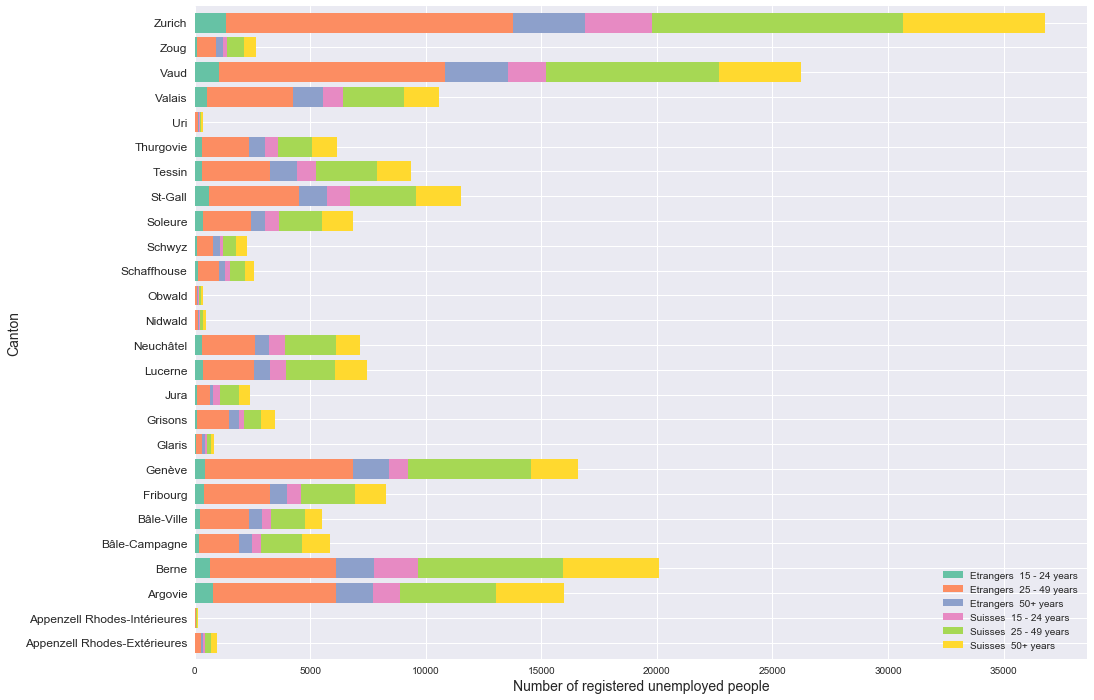

In [22]:
sns.set_palette("Set2")
fig, ax = plt.subplots(figsize=(16,12))
switzerland_age_df.plot.barh(stacked=True, grid=True, width=0.8, ax=ax)
plt.xlabel('Number of registered unemployed people',fontsize=14)
plt.ylabel('Canton', fontsize=14)
plt.yticks(fontsize=12)
plt.legend()

# BONUS 

using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

## First step: Plot the Rostigraben map

In [23]:
def rostigraben_colors(feature_id):
    IT = ['TI']
    FR = ['GE', 'VD', 'FR', 'NE', 'VS', 'JU']
    
    if feature_id in IT:
            return '#4daf4a';
    elif feature_id in FR:
        return '#377eb8'
    else:
        return '#e41a1c'

In [24]:
rostigraben_map = folium.Map([46.8001, 8.1958], tiles='cartodbpositron', zoom_start=8)



rostigraben_map.choropleth(geo_data=geo_json_data, data=switzerland_suisses_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0,
             legend_name='Unemployment rate - Swiss population (%)',
             name='Unemployment rates - Swiss population',
             topojson='objects.cantons', threshold_scale=define_threshold(switzerland_suisses_df, 'unemployment_rate', 'equal', 5))

rostigraben_map.choropleth(geo_data=geo_json_data, data=switzerland_strangers_df,
             columns=['code', 'unemployment_rate'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.3, line_opacity=0,
             legend_name='Unemployment rate - Foreign population (%)', 
             name='Unemployment rates - Foreign population',
             topojson='objects.cantons', threshold_scale=define_threshold(switzerland_strangers_df, 'unemployment_rate', 'equal', 5))

folium.TopoJson(
    switzerland_topojson_path,
    name = 'Languages spoken according to Rostigraben',
    object_path ='objects.cantons',
    style_function=lambda feature: {
        'fill_color': 'white',
        'fillOpacity': 0,
        'weight' : 3,
        'color': rostigraben_colors(feature['id']),
        'opacity': 1
        
    }
).add_to(rostigraben_map)

folium.LayerControl(collapsed=False).add_to(rostigraben_map)
rostigraben_map

## Observations